## [SF-DST] Restaurant Rating prediction.
Предскажите рейтинг ресторана по версии TripAdvisor

In [1]:
from collections import Counter
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
RANDOM_SEED = 13
!pip freeze > requirements.txt

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_test['Rating'] = 0
df_test['sample'] = 0
df_train['sample'] = 1

df = pd.concat([
    df_train,
    df_test
]).reset_index(drop=True)

df.columns = [
    'rest_id', 'city', 'cuisine', 'ranking', 'rating', 'price_range', 'num_reviews', 'reviews', 'url_ta', 'id_ta', 'sample'
]

# Обзор датасета

In [6]:
print("В объединенном наборе данных", df.shape[0], "строк и", df.shape[1], "колонок")
df.head(3)

В объединенном наборе данных 50000 строк и 11 колонок


,rest_id,city,cuisine,ranking,rating,price_range,num_reviews,reviews,url_ta,id_ta,sample
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1


In [7]:
df.isna().sum()

rest_id            0
city               0
cuisine        11590
ranking            0
rating             0
price_range    17361
num_reviews     3200
reviews            2
url_ta             0
id_ta              0
sample             0
dtype: int64

# Анализируем колонки

## rating

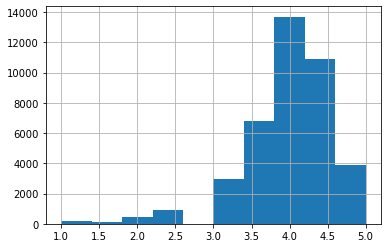

In [8]:
df[df['sample']==1].rating.hist();

## rest_id

In [9]:
print('уникальный ресторанов', df.rest_id.nunique())
print('среди тестовых строк уникальных ресторанов ', df[df['sample'] == 0].rest_id.nunique())
print('всего строк', df.shape[0])

уникальный ресторанов 13094
среди тестовых строк уникальных ресторанов  10000
всего строк 50000


получается что rest_id это не уникальный номер ресторана, а может быть это номер сети, тогда это можно использовать как признак  
сделаем из него таблицу dummy колонок

In [10]:
rest_id_dummy = pd.get_dummies(df[['rest_id']], prefix="rest_id_")
print(rest_id_dummy.shape)

(50000, 13094)


## city

In [11]:
print("всего городов", df.city.nunique())
df.city.value_counts()[:10]

всего городов 31


London       7193
Paris        6108
Madrid       3813
Barcelona    3395
Berlin       2705
Milan        2694
Rome         2589
Prague       1816
Lisbon       1647
Vienna       1443
Name: city, dtype: int64

Сделаем dummy колонки по каждому городу

In [12]:
city_dummies = pd.get_dummies(df.city, prefix="city_")
print(city_dummies.shape)

(50000, 31)


## cuisine

In [13]:
df.cuisine.head(3)

0              ['European', 'French', 'International']
1                                                  NaN
2    ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...
Name: cuisine, dtype: object

In [14]:
df.cuisine.fillna("['Other']", inplace=True)

In [15]:
def get_clean_list_of_cuisines(entry_node):
    """
    Функция из строки вида: ['European', 'French', 'International']
    делает list
    """
    if entry_node is np.nan:
        return entry_node
    entry_node = entry_node[1:-1]
    return [x.strip()[1:-1] for x in entry_node.split(',')]


test_row = "['European', 'French', 'International']"
print("тест", get_clean_list_of_cuisines(test_row))

тест ['European', 'French', 'International']


In [16]:
df.cuisine = df.cuisine.apply(
    get_clean_list_of_cuisines
)

In [17]:
stacked_cuisines = df.cuisine.apply(pd.Series).stack()

In [18]:
stacked_cuisines.value_counts()[:10]

Vegetarian Friendly    14021
European               12561
Other                  11590
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
dtype: int64

Итого у нас есть 126 видов кухонь, включая na значение, которые мы заменили на Other  
Самое распространенное меню - вегетарианское

In [19]:
for cuis in stacked_cuisines.value_counts().index[:10]:
    mask = df.cuisine.apply(lambda x: cuis in x)
    print(cuis, df.loc[mask & df['sample'] == 1].rating.mean())

Vegetarian Friendly 4.130708731790151
European 4.048210735586481
Other 3.9465151351933643
Mediterranean 4.071530986139876
Italian 4.028923541247485
Vegan Options 4.2225813642443155
Gluten Free Options 4.1893994651106246
Bar 3.9525326053988477
French 4.0227272727272725
Asian 3.982896047824643


Различия среднего по видам кухни есть, но я бы не сказал что уж очень сильное, и скорее это шум.  
Сделаем также dummy колонки по видам кухонь

In [20]:
cuisine_dummy = pd.get_dummies(stacked_cuisines, prefix="cuisine_").sum(level=0)

## ranking

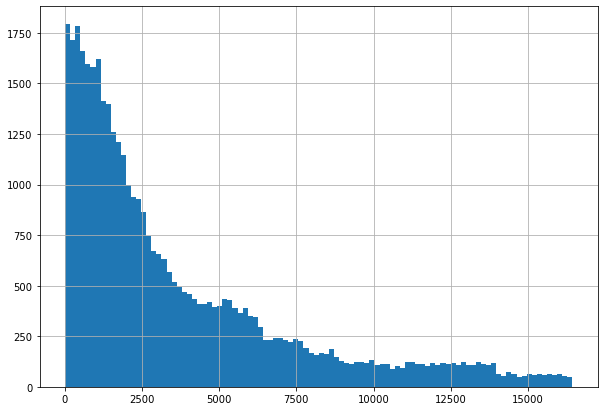

In [21]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100);

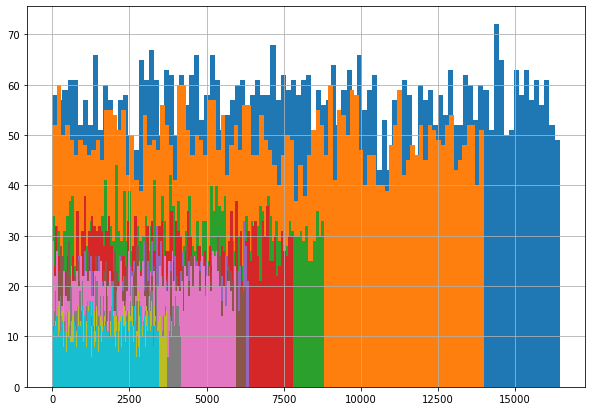

In [22]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Чем больше в городе ресторанов, тем больше значений ranking в нем.  
Сделаем нормализацию признака внутри каждого города

In [23]:
group_by_city_scalers = {}
scaled_ranking_rows = []
for name, rows in df.groupby('city').ranking:
    city_scaler = MinMaxScaler()
    scaled_rows = city_scaler.fit_transform(pd.DataFrame(rows))
    scaled_ranking_rows.append(
        pd.DataFrame(scaled_rows, index=rows.index)
    )
    group_by_city_scalers[name] = city_scaler
df['ranking_skaled_by_city'] = pd.concat(scaled_ranking_rows, axis=0)

## price_range

In [24]:
price_values = {'$': 0, '$$ - $$$': 1, '$$$$': 2}
df.price_range = df.price_range.replace(price_values)

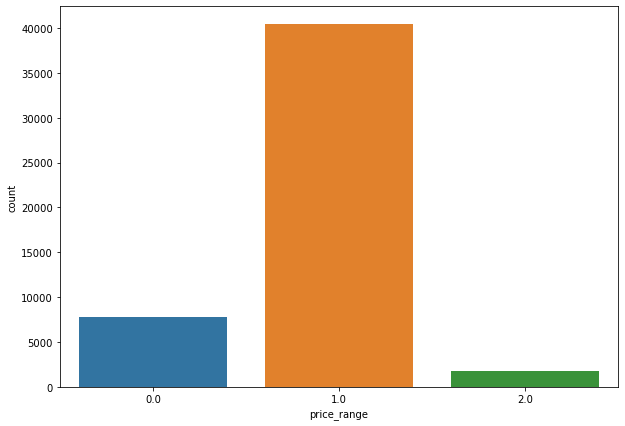

In [25]:
df['price_range_is_na'] = df.price_range.isna().astype(int)
df.price_range.fillna(df.price_range.median(), inplace=True)
sns.countplot(df.price_range);

По этому признаку - он порядковый. заменим пропуски на среднее значение - 1  
и добавим признак - price_range_is_na

## num_reviews

In [26]:
df['num_reviews_is_na'] = pd.isna(df['num_reviews']).astype('uint8')
df.num_reviews.fillna(0, inplace=True)

Просто заполним пропуски 0, и вынесим пропуски в отдельный признак

## reviews

In [27]:
df.loc[0, 'reviews']

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

Колонка содержим 2 отзывы и 2 даты  
Сделаем поиск ключевых плохих слов отдельными признаками, но сначала немножко преобразуем признак

In [28]:
df['reviews'] = df.reviews.str.lower()
df['reviews'].fillna('', inplace=True)

In [29]:
def get_reviews(entry_node):
    if entry_node is np.nan:
        return entry_node
    entry_node = entry_node[1:-1]
    return [x.strip().replace('[','').replace(']','').replace("'","").split(',') for x in entry_node.split('],')]

In [30]:
word_good_markers = ['great','excelent', 'best', 'delicious']
word_bad_markers = ['poor','worse','weird', 'disappointing', 'annoying', 'don\'t']

In [31]:
df['good_words'] = df.reviews.str.count('|'.join(word_good_markers))
df['bad_words'] = df.reviews.str.count('|'.join(word_bad_markers))

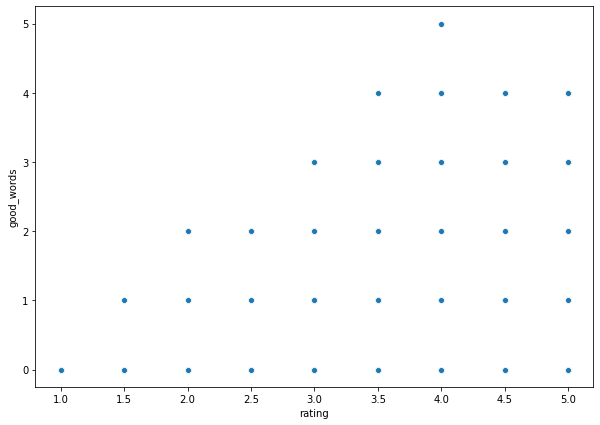

In [32]:
sns.scatterplot(data=df[df['sample'] == 1], x='rating', y='good_words');

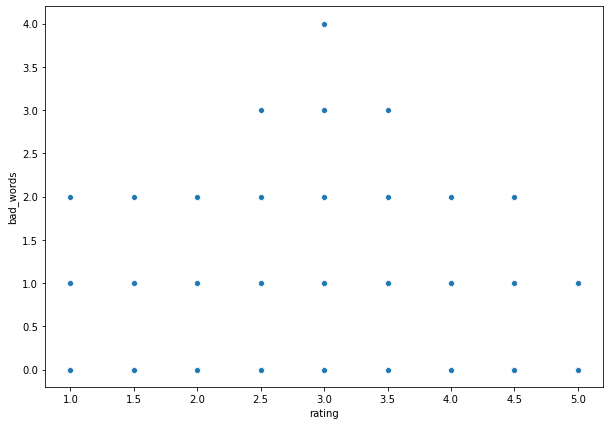

In [33]:
sns.scatterplot(data=df[df['sample'] == 1], x='rating', y='bad_words');

# Моделирование

## Собираем dataset

In [34]:
united_df = pd.concat([
        rest_id_dummy,
        city_dummies,
        cuisine_dummy,
        df[['ranking_skaled_by_city', 'price_range', 'price_range_is_na', 'num_reviews', 'num_reviews_is_na', 'good_words','bad_words', 'sample', 'rating']]        
], axis=1)
X.shape

NameError: name 'X' is not defined

## Учебное моделирование

In [35]:
X = united_df[united_df['sample'] == 1].drop(['rating','sample'], axis=1)
y = united_df[united_df['sample'] == 1].rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.196433


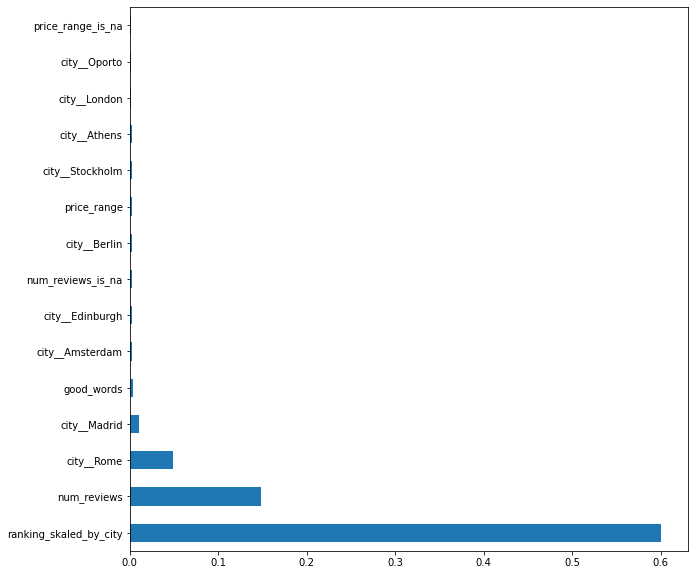

In [36]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Самбит

In [37]:
X = united_df[united_df['sample'] == 1].drop(['rating','sample'], axis=1)
y = united_df[united_df['sample'] == 1].rating
regr.fit(X, y)

RandomForestRegressor(random_state=13)

In [38]:
X = united_df[united_df['sample'] == 0].drop(['rating','sample'], axis=1)
sample_submission['Rating'] = regr.predict(X)
sample_submission.to_csv('submission.csv', index=False)